In [2]:
import torch

In [3]:
ckp = torch.load('./asf_checkpoint.pth', map_location='cpu')

In [5]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import xml.dom.minidom as xmldom


In [6]:
img_path = './test_samples/imgs/1004.jpg'
gt_path = './test_samples/gt/0001004.txt'

def get_img(img_path):
    img = cv2.imread(img_path)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def get_ann(gt_path):
    boxes = []
    with open(gt_path, 'r') as f:
        content = f.readlines()
    for i in range(len(content)):
        box = content[i].split(',')[:-1]
        box = [int(x) for x in box]
        box = np.array(box, dtype=np.int32).reshape(-1, 2)
        boxes.append(box)
    return boxes

In [7]:
img = get_img(img_path)
boxes = get_ann(gt_path)

In [8]:
img_box = cv2.polylines(img, boxes, True, (0, 255, 255), 2)

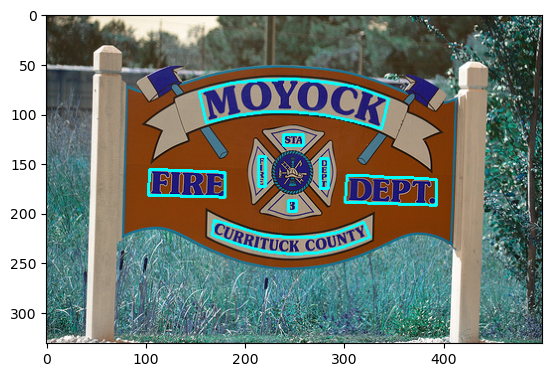

In [9]:
plt.imshow(img_box)

In [10]:
from datasets.make_shrink_map import shrink

In [11]:
shrink_box = shrink(boxes, 0.4)

In [12]:
img_box_shrink = cv2.polylines(img_box, shrink_box, True, (0, 255, 0), 2)

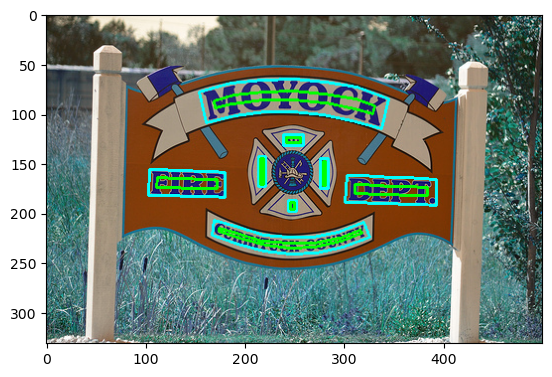

In [13]:
plt.imshow(img_box_shrink)

In [14]:
cv2.imwrite('./img_shrink_box.jpg', img_box_shrink)

True

In [15]:
import torch
from torch import nn
from utils.utilers import get_config

In [16]:
from models.model import PAN

In [19]:
config = get_config('./asf-config.yaml')
model = PAN(config['backbone'], config['neck_param'], config['head_param'])

In [ ]:
model.load_state_dict(ckp)

In [37]:
x = torch.randn(2, 3, 640, 640)
model(x)

---backbone
torch.Size([2, 64, 160, 160])
torch.Size([2, 128, 80, 80])
torch.Size([2, 256, 40, 40])
torch.Size([2, 512, 20, 20])
---reduce
torch.Size([2, 128, 160, 160]) torch.Size([2, 128, 80, 80]) torch.Size([2, 128, 40, 40]) torch.Size([2, 128, 20, 20])
---FPEM
torch.Size([2, 128, 160, 160]) torch.Size([2, 128, 80, 80]) torch.Size([2, 128, 40, 40]) torch.Size([2, 128, 20, 20])
---before det
torch.Size([2, 128, 160, 160]) torch.Size([2, 128, 160, 160]) torch.Size([2, 128, 160, 160]) torch.Size([2, 128, 160, 160])
---after-det
torch.Size([2, 6, 160, 160])
final_out: torch.Size([2, 6, 640, 640])


tensor([[[[-7.3496e+00, -7.3496e+00, -7.3484e+00,  ..., -1.4367e+01,
           -1.4693e+01, -1.4693e+01],
          [-7.3496e+00, -7.3496e+00, -7.3484e+00,  ..., -1.4367e+01,
           -1.4693e+01, -1.4693e+01],
          [-7.2167e+00, -7.2167e+00, -7.2760e+00,  ..., -1.3723e+01,
           -1.3925e+01, -1.3925e+01],
          ...,
          [-8.1786e-01, -8.1786e-01, -8.4199e-01,  ...,  3.5040e-01,
            8.1878e-02,  8.1878e-02],
          [-3.8521e-01, -3.8521e-01, -3.8153e-01,  ...,  2.5743e+00,
            2.2692e+00,  2.2692e+00],
          [-3.8521e-01, -3.8521e-01, -3.8153e-01,  ...,  2.5743e+00,
            2.2692e+00,  2.2692e+00]],

         [[-1.6093e-01, -1.6093e-01, -1.7446e-01,  ...,  8.2531e+00,
            8.4020e+00,  8.4020e+00],
          [-1.6093e-01, -1.6093e-01, -1.7446e-01,  ...,  8.2531e+00,
            8.4020e+00,  8.4020e+00],
          [-1.7666e-01, -1.7666e-01, -1.8669e-01,  ...,  8.2551e+00,
            8.4689e+00,  8.4689e+00],
          ...,
     